# The HFM library - A fast marching solver with adaptive stencils

## Part : Non holonomic metrics and curvature penalization
## Chapter : Vehicles with trailers

We compute globally minimal paths for an omni-directional vehicle equipped with one or two trailers.
For that purpose, we numerically solve sub-Riemannian eikonal equations in dimension three and four. The numerical scheme is GPU accelerated, with features aimed to reduce numerical diffusion. The extracted trajectories are validated by comparison with a geodesic shooting method.

**References.**

The numerical scheme used in this notebook is described and studied in detail in the following publication:
* Mirebeau, J.-M. (2019). Riemannian Fast-Marching on Cartesian Grids, Using Voronoi's First Reduction of Quadratic Forms. SIAM Journal on Numerical Analysis, 57(6), 2608–2655.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Mathematical framework](#1.-Mathematical-framework)
    * [1.1 The vehicle models](#1.1-The-vehicle-models)
    * [1.2 Properties of the models](#1.2-Properties-of-the-models)
    * [1.3 Sub-Riemannian formalism](#1.3-Sub-Riemannian-formalism)
    * [1.4 Numerical implementation](#1.4-Numerical-implementation)
  * [2. One trailer](#2.-One-trailer)
    * [2.1 Control vector fields](#2.1-Control-vector-fields)
    * [2.2 Input](#2.2-Input)
    * [2.3 Special motions](#2.3-Special-motions)
    * [2.4 Comparison with the Reeds-Shepp model](#2.4-Comparison-with-the-Reeds-Shepp-model)
  * [3. Two trailers](#3.-Two-trailers)
    * [3.1 Control vector fields](#3.1-Control-vector-fields)
    * [3.2 Input](#3.2-Input)
    * [3.3 Special motions](#3.3-Special-motions)
    * [3.4 Comparison with the Reeds-Shepp car](#3.4-Comparison-with-the-Reeds-Shepp-car)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Trailers','FMM'))

In [2]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import LinearParallel as lp
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np; xp=np; allclose = np.allclose
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,allclose
    Eikonal,ad,cugen,allclose = rreload([Eikonal,ad,cugen,allclose],"..")
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

The experiments presented in this notebook require the GPU accelerated solver. 
(Adapting them for the cpu solver would not be too difficult, although computation times would be longer.)

In [5]:
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError("cupy module not found")

In [6]:
xp,Eikonal,plt,allclose = [ad.cupy_friendly(e) for e in (xp,Eikonal,plt,allclose)]

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting float32 compatible default values atol=rtol=1e-5 in np.allclose


## 1. Mathematical framework

The goal of this section is to describe the models of interest in terms of controls $(v_i)$, and complementary controls $(w_i)$ (associated to forbidden motions) whose efficiency is determined by a small relaxation parameter $\epsilon > 0$. The resulting quadratic hamiltonian if defined as 
$$
    H(q,p) = \frac 1 2 \Big (\sum_i <v_i(q),p>^2 + \epsilon^2 \sum_i <w_i(q),p>^2\Big).
$$

In [7]:
def Hamiltonian(controls,complement,ϵ=0.1):
    """
    The quadratic Hamiltonian associated to a family of control vector fields, 
    and relaxed with a family of complementary vector fields.
    """
    return lp.outer_self(controls).sum(axis=2) + lp.outer_self(ϵ*complement).sum(axis=2) 

### 1.1 The vehicle models

**Omni-directional vehicle.** Our starting point is a vehicle able to move in any direction in the plane, at unit Euclidean speed. Denote by $X \in R^2$ its position. In control theoretic terms, the evolution of $X$ is expressed in an orthonormal basis $(e,e^\perp)$ of the plane, and determined by two controls $(\alpha, \beta)$ in the unit ball.
$$
    \dot X = \alpha e + \beta e^\perp, \qquad \alpha^2 + \beta^2 \leq 1.
$$


**Case of one trailer.** Let us attach a trailer to the preceding vehicle. The trailer is rigid and has fixed length $r>0$, also denoted $r=1/\kappa$ where $\kappa$ can be regarded as a typical curvature. The full vehicle state is now $(X,\theta) \in R^2 \times S^1$, where $e(\theta) := (\cos \theta , \sin \theta)$ is colinear to the trailer direction and directed toward the (omni-directional) head. The trailer state cannot be controlled directly, thus the evolution of $(X,\theta)$ is again determined by two controls $(\alpha,\beta)$ in the unit ball and reads 
$$
    \begin{pmatrix}
    \dot X\\
    \dot \theta
    \end{pmatrix}
    {=}
    \alpha 
    \begin{pmatrix}
    e(\theta)\\
    0
    \end{pmatrix}
    {+}
    \beta
    \begin{pmatrix}
    e(\theta)^\perp\\
    \kappa
    \end{pmatrix}.
$$
Note that we use a block notation for vectors; for instance $(X,\theta) := (X_0,X_1,\theta)$ if $X = (X_0,X_1) \in R^2$.
A few remarks are in order:
- The head $X$ of the vehicle follows the same dynamics as in the previous simpler model, only expressed in the peculiar orthonormal basis $e((\theta),e(\theta)^\perp)$. Again, the head can always move in any direction, at unit Euclidean speed.
- If the head moves in the direction $e(\theta)$, aligned with the trailer direction, then the latter is only trailing behing and its orientation does not change, as expected.
- A special motion of interest is when the head moves in circles of radius $r = 1/\kappa$ in the direction $e(\theta)^\perp$, so that the rear wheels of the trailer do not move, although its angle $\theta$ changes continuously. The second control vector corresponds, at first order, to this motion.

**Case of two trailers.**
Let us attach a second trailer at to the preceding vehicle, at the back of the first trailer. The additional trailer is again rigid, and has fixed length $r'>0$, also denoted $r' = 1/\kappa'$. The angle of the second trailer is again denoted $\phi$. The vehicle state $(X,\theta,\phi) \in R^2 \times S^1 \times S^1$ is now four dimensional, but still only two controls $(\alpha, \beta)$ are available. The evolution equation reads:
$$
    \begin{pmatrix}
    \dot X \\
    \dot \theta \\
    \dot \phi
    \end{pmatrix}
    {=}
    \alpha 
    \begin{pmatrix}
    e(\theta) \\
    0 \\
    \kappa' \sin(\theta-\phi)
    \end{pmatrix}
    {+}
    \beta
    \begin{pmatrix}
    e(\theta)^\perp \\
    \kappa \\
    0
    \end{pmatrix}
$$
- Control $\alpha$ corresponds to the vehicle moving forward, so that the first trailer orientation is not affected, but the second trailer tends to align with the first one.
- Control $\beta$ corresponds to the omni-directional head moving into circles of radius $r=1/\kappa$, leaving in place the rear wheels of the first trailer, as described above. The second trailer is unaffected by this motion.

### 1.2 Properties of the models

**Commutators.**
Denote by $\omega_0$ and $\omega_1$ the two control vector fields of (one of our three) models. In the trailer-less case, $\omega_0$ and $\omega_1$ span the plane $R^2$. In other words, any tangent vector to the state space $R^2$ can be realized by a suitable linear combination $\alpha\omega_0+ \beta \omega_1$.

As soon as one trailer is attached, the two vectors vector fields $\omega_0,\omega_1$ fail to span the tangent space to the state space $R^2 \times S^1$, which is three dimensional. The model is said non-holonomic. Alternating small (first-order) displacements along $\omega_0$ and $\omega_1$ one may however realize a motion (second-order small) in a direction $\omega_2$ which is not a linear combination of $\omega_0$ and $\omega_1$, namely here $\omega_2 = (e(\theta)^\perp,0)$. One says that $\omega_2$ is the commutor of $\omega_0$ and $\omega_1$.

When two trailers are attached, the two vector fields $\omega_0, \omega_1$ and their first order commutator $\omega_2$ still do not span the tangent space to the state space $R^2 \times S^1 \times S^1$, which is four dimensional. Yet another commutator, of $\omega_2$ with $\omega_0$ or $\omega_1$ is required for that purpose, and one says that the model is sub-Riemannian of rank two.


**Comparison with the Reeds-Shepp model.**

To (some) mathematicians, wether the dog is wagging the tail, or the tail is wagging the dog, is only a question of coordinate system choice. Following that rationale, and we denote by $Y = X - r e(\theta)$ the position of the tail of the trailer, in the single trailer case. One easily checks that 
$$
    \begin{pmatrix}
    \dot Y \\
    \dot \theta 
    \end{pmatrix}
    {=} 
    \alpha
    \begin{pmatrix}
    e(\theta) \\
    0
    \end{pmatrix}
    {+}
    \beta
    \begin{pmatrix}
    0 \\
    \kappa
    \end{pmatrix}.
$$
This particular optimal control model is known as the Reeds-Shepp car, and best represents a wheelchair-like vehicle. Up to a coordinate change, it is thus isomorphic to the omni-directional vehicle with a single trailer. 
(Implementation-wise, one notable difference is that the the Reeds-Shepp hamiltonian is block diagonal with sizes (2,1), in contrast with the original model which has no such structure.)

The omni-directional vehicle with two trailers is, likewise, isomorphic to a Reeds-Shepp car with a single trailer.

### 1.3 Sub-Riemannian formalism

**Optimal control.** Denote by $\Omega$ a sub-domain of the state space (for our models $R^2$, $R^2 \times S^1$ or $R^2 \times S^1 \times S^1$). 
Denote by $\omega_0, \cdots, \omega_n$ the control vector fields (for our models $n=1$), and by $\alpha_0, \cdots, \alpha_n$ the related controls (for our models denoted $\alpha, \beta$).

Our objective is to evaluate the minimal cost $U(z)$ of a path from a reference seed point $z_0$ to a given point $z$. More precisely, 
$$
    U(z)^2 = \min_{\alpha_0,\cdots,\alpha_n}\int_0^1 (\alpha_0(t)^2 +\cdots+ \alpha_n(t)^2) dt,
$$
subject to the following constraint: one has $Z(1) = z$, where $Z : [0,1] \to \Omega$ is the path characterized by $Z(0) = z_0$ and for all $0 \leq t \leq 1$
$$
    \dot Z(t) = \alpha_0(t) \omega_0(Z(t)) + \cdots + \alpha_n(t) \omega_n(Z(t)).
$$

**Eikonal equation.** The value function $U : \Omega \to R$ is, under suitable assumptions, the unique viscosity solution of the sub-Riemannian eikonal equation. More precisely, one has $U(z_0) = 0$, outflow boundary conditions on $\partial \Omega$, and for all $z \in \Omega$ 
$$
    \|\nabla u(z)\|_{D(z)} = 1,
$$
where $D(z) = \omega_0(z) \omega_0(z)^T + \cdots + \omega_n(z) \omega_n(z)^T$ is the sum of the self outer-products of the control vector fields.
Note that $D(z)$ is a positive semi-definite matrix, which is rank deficient unless $(\omega_0(z), \cdots,\omega_n(z))$ span the tangent space. The function $H(q,p) := \frac 1 2 <p,D(q)p>$ is referred to as the Hamiltonian of the system.

**Riemannian relaxation.**
Denote by $\tilde \omega_0, \cdots , \tilde \omega_{\tilde n}$ a family of vector fields which, together with $\omega_0, \cdots, \omega_n$, span the tangent space to the state space. Let also $\tilde D := \tilde\omega_0(z) \tilde\omega_0(z)^T + \cdots + \tilde\omega_{\tilde n}(z) \cdots \tilde \omega_{\tilde n}(z)^T$, and for any $\epsilon >0$
$$
    D_\epsilon(z) := D(z) + \epsilon^2 \tilde D(z).
$$
Then $D_\epsilon(z)$ is a positive definite (full rank) matrix, and the Riemannian eikonal equation 
$$
    \|\nabla u_\epsilon(z)\|_{D_\epsilon(z)} = 1,
$$
is referred to as the $\epsilon$-relaxation of the sub-Riemannian eikonal equation. The Riemannian eikonal equation can be discretized using the techniques which are standard in this series of notebooks, see below. For sufficiently small $\epsilon>0$, the solution $u_\epsilon$ to the Riemannian relaxation is close to the solution $u$ of the original sub-Riemannian equation, see the reference.

<!---
### 1.2 Sub-Riemannian formalism

**Describing a sub-Riemannian model.**

Sub-Riemannian geometry is a limit case of Riemannian geometry, where the cost of motion in certain directions tends to infinity. Heuristically, one could say that some of the eigenvalues of the Riemannian metric tensor tend to infinity.
A simpler and more rigorous approach is to consider the matrix of the Hamiltonian, defined as the inverse of the Riemannian tensor, which in the sub-Riemannian case is rank-deficient.

Our numerical approach to solving eikonal equations does however require a positive definite Hamiltonian. We thus introduce a relaxation parameter $\epsilon>0$ and consider 
$$
    D(x) = D_0(x) + \epsilon^2 D_1(x),
$$
where $D_0$ is the rank deficient hamiltonian of interest, and $D_1$ is introduced so that the sum $D$ is positive definite. By assumption, $D_0$ and $D_1$ must be positive semi-definite.
If $\epsilon$ is small, then the Riemannian eikonal equation based on the matrix $D$, 
$$
\|\nabla u(x) \|_{D(x)} = 1
$$
is a good enough approximation of the sub-Riemannian eikonal equation, involving $D_0$ instead. We denoted $\|v\|_D := \sqrt{<v,Dv>}$.
--->

### 1.4 Numerical implementation

**Discretization of the eikonal equation.**
Assume that a tensor field $D$ admits a decomposition of the type
$$
    D = \sum_{i \in I} \lambda_i e_i e_i^T,
$$
where the index set $I$ is finite, $\lambda_i \geq 0$ is a non-negative weight, and $e_i \in Z^d$ is an offset with integer coordinates, for each $i \in I$.
The pointwise dependency of $D=D(x)$, $\lambda_i=\lambda_i(x)$, $e_i=e_i(x)$ is omitted for readability.
We discretize the Riemannian eikonal equation based on the following finite differences approximation:
$$
    \|\nabla u(x)\|_{D(x)}^2 \approx h^{-2} \sum_{i \in I}\lambda_i \max\{0,u(x)-u(x-h e_i), u(x)-u(x+h e_i)\}^2.
$$
This resulting numerical scheme enjoys properties (monotony, causality) which allow to establish the convergence and stability of the method, and to implement it efficiently, see the reference above.

**Tensor decomposition techniques and their limitations.**
[Selling's](../Notebooks_Algo/TensorSelling.ipynb) and [Voronoi's](../Notebooks_Algo/TensorVoronoi.ipynb) matrix decompositions, are our main tools for obtaining the tensor decomposition presented above. They do require however, that the matrices $D(z)$, $z \in \Omega$, be positive definite. In fact, no such decomposition exists for semi-definite matrices in general.

In the case of a sub-Riemannian eikonal equation, involving a rank deficient tensor field $D$, we thus apply the previous approach to the Riemannian relaxation $D_\epsilon$.

<!---
**Numerical diffusion and pruning.**
Consider a decomposition of a Riemannian relaxation $D_\epsilon = D + \epsilon^2 \tilde D$, and note that the Frobenius norm of $D_\epsilon$ can be expressed as follows:
$$
    \mathrm{Tr}(D_\epsilon^2) = \sum_{i \in I} \lambda_i (\|e_i\|_D^2 + \epsilon^2 \| e_i \|_{\tilde D}^2),
$$
where all the contributions are non-negative.
The pruning step eliminates from the numerical scheme all offsets such that $\|e_j\|_D \leq \epsilon \|e_j\|_{\tilde D}$, which helps moderate the numerical diffusion, while maintaining the consistency with the sub-Riemannian eikonal equation as $\epsilon \to 0$.
--->

## 2. One trailer

We implement the rank one sub-Riemannian model corresponding to an omni-directional car with a single trailer.

### 2.1 Control vector fields

We reproduce the two control vector fields defining the model, whose mathematical expression is given in the first section.

In [8]:
θs = xp.linspace(0,2*np.pi,96)

In [9]:
def ω(θ,κ=1):
    z,u = np.zeros_like(θ), np.ones_like(θ)
    return np.stack(ad.asarray([
        [ np.cos(θ),np.sin(θ),  z],
        [-np.sin(θ),np.cos(θ),κ*u]
    ]),axis=1)

We also introduce one additional control vector field, used in the Riemannian relaxation, which together with the first two spans the tangent space.

In [10]:
def ω_(θ,κ=1):
    u = np.ones_like(θ)
    return np.stack(ad.asarray([
        [κ*np.sin(θ),-κ*np.cos(θ),u]
    ]),axis=1)

The additional vector field is orthogonal to the two basic fields. This is a common choice, although it is not required.

<!---
We now implement the sum $D = \omega_0\omega_0^T+ \cdots+ \omega_n \omega_n^T$ of the self outer products of some vectors.
As mentioned in the introduction, this is a semi-definite matrix, which is rank deficient unless the vectors $(\omega_0,\cdots,\omega_n)$ span $R^d$. 

If $\omega_1,\cdots,\omega_n$ are the control vector fields, then $D$ defines the sub-Riemannian hamiltonian. In the full-rank Riemannian case, it is also the matrix inverse, or dual, of the metric.

def ω2D(ω): 
    """
    DUAL of the (sub-)Riemannian metric 
    defined by a family of control vector fields.
    """
    return Metrics.Riemann(lp.outer_self(ω).sum(axis=1))
--->

<!---
We choose not to store this data in the `Metrics.Riemann` class, since it is 
**Important note.**
In most notebooks, the *Metrics.Riemann* class is used to store a
The next function evaluates the sum $\omega_0\omega_0^T+ \cdots+ \omega_n \omega_n^T$
--->

In [11]:
assert allclose(lp.dot_VV(ω(θs),ω_(θs)),0)

In [12]:
κ=2
H = Hamiltonian(ω(θs,κ),ω_(θs,κ))
print(f"Shape of the dual metric {H.shape}")

Shape of the dual metric (3, 3, 96)


Inspecting one of these matrices we find:
* A ratio $0.1^2$ between the smallest and largest eigenvalue, which is expected (approximately) in view of the default relaxation parameter $\epsilon = 0.1$ in `Hamiltonian`.
* A tensor decomposition involving 6 non-zero weights with distinct offsets. This decomposition defines the stencil of the numerical scheme.

In [13]:
Hi = H[:,:,10]
print(f"Eigenvalues {np.linalg.eigvalsh(Hi)}")
Eikonal.VoronoiDecomposition(Hi)

Eigenvalues [ 0.05     1     5]


(array([0.168, 0.684, 0.358,  0.35, 0.0133, 0.149], dtype=float32),
 array([[ 1, -1,  0,  0,  1, -1],
        [-1,  0, -1,  1,  0, -1],
        [-3,  1, -1,  2, -2,  0]]))

### 2.2 Input

In [14]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann3',
    'seed':[0,0,0],
    'periodic':[True,True,True],
})
hfmIn.SetRect([[-1,1],[-1,1],[-np.pi,np.pi]],dims = [101,101,96])
hfmIn['origin'][2] -= hfmIn['gridScales'][2]/2 # Angular grid starts at -pi
hfmIn.SetUniformTips([4,4,4])

Our metric is translation invariant w.r.t the first two coordinates $X = (X_0,X_1)$, only depending on the *last coordinate* the angle $\theta$. This structure is relatively common, and the HFM library will take advantage of it to save some memory and compute less stencils.

More generally, metrics depending only on some of the final coordinates $(x_k,...,x_n)$ are implicitly regarded invariant w.r.t the first coordinates, see also the two trailer case in the next section. (This is a form of broadcasting.)

In [15]:
_,_,aθ = hfmIn.Axes()
assert np.allclose(aθ[0],-np.pi)

In [16]:
r=0.5 # Length of the trailer
κ=1/r
hfmIn['dualMetric'] = Metrics.Riemann(Hamiltonian(ω(aθ,κ), ω_(aθ,κ)))

In [17]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.1360006332397461 seconds, and 62 iterations.
Post-Processing


Displaying all the (planar projections of the) geodesics produces an elegant figure, but very little information.

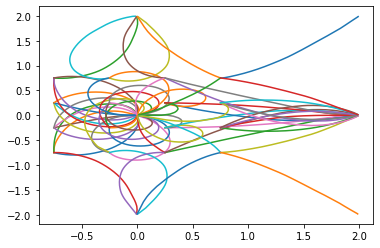

In [18]:
for geo in hfmOut['geodesics']:
    plt.plot(*geo[:2])

We show below the trajectory of the omni-directional vehicle in blue, the back of the trailer in red, and draw a family of lines representing the trailer body at different as time progresses.

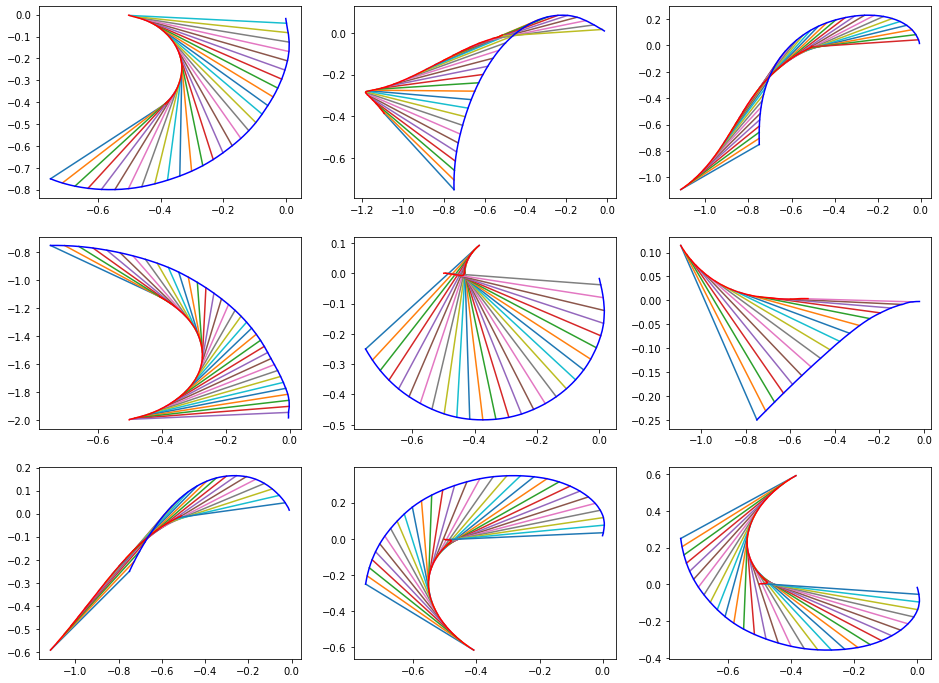

In [19]:
nx,ny=3,3
plt.figure(figsize=(16,12*ny/nx))
for i,geo in enumerate(hfmOut['geodesics']):
    if i>=nx*ny: break
    plt.subplot(ny,nx,1+i)
    front = geo[:2]
    orient = geo[2]
    back = geo[:2] - r*ad.array((np.cos(orient),np.sin(orient)))
    plt.plot(*np.stack((front,back),axis=1)[:,:,::10]);
    plt.plot(*back,color='red')    
    plt.plot(*front,color='blue')

### 2.3 Special motions

Other motions of interest include parallel parking, and half turn.

In [20]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann3',
    'seed':[0,0,0],
    'periodic':[True,True,True],
    'traits':{'niter_i':3}, # Performance related (iterations within a block)
})
#hfmIn.SetRect([[-1,1],[-1,1],[-np.pi,np.pi]],dims = [101,101,96])
hfmIn.SetRect([[-1,1],[-1,1],[-np.pi,np.pi]],dims = [201,201,192])
hfmIn['origin'][2] -= hfmIn['gridScales'][2]/2 # Angular grid starts at -pi

_,_,aθ = hfmIn.Axes()
r=0.5; κ=1/r # Length of the trailer, typical curvature
hfmIn['dualMetric'] = Metrics.Riemann(Hamiltonian(ω(aθ,κ), ω_(aθ,κ),ϵ=0.05))

In [21]:
hfmIn['tips'] = [
    (0, 1.,0), # Parallel parking, far
    (0,0.5,0), # Parallel parking
    (0,0.2,0), # Parallel parking, close
    (   0,0,np.pi), # Half turn, leaving head in place
    (  -r,0,np.pi), # Half turn, exchanging head and tail
    (-2*r,0,np.pi), # Half turn, leaving tail in place
]

In [22]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4000051021575928 seconds, and 115 iterations.
Post-Processing


As before, we show the omni-directional head in blue, and the tail of the trailer in red.
* First line : parallel parking.
* Second line : half turn.

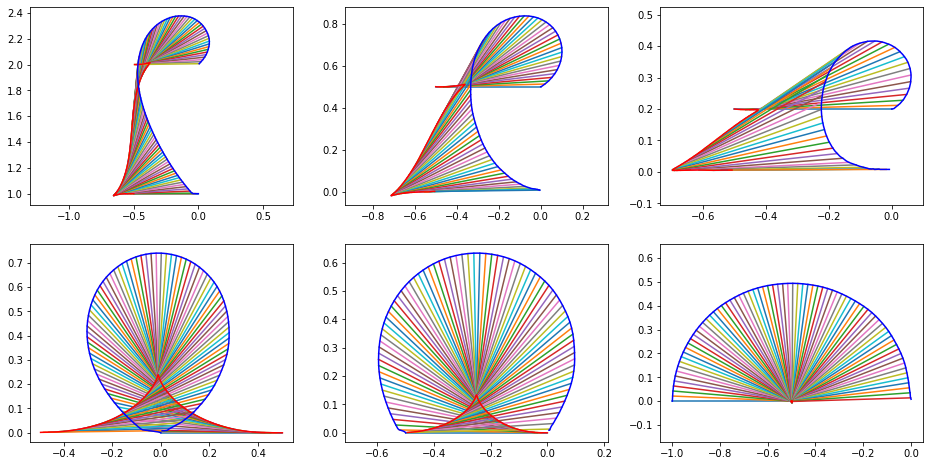

In [23]:
nx,ny=3,2
plt.figure(figsize=(16,12*ny/nx))
for i,geo in enumerate(hfmOut['geodesics']):
    if i>=nx*ny: break
    plt.subplot(ny,nx,1+i)
    front = geo[:2]
    orient = geo[2]
    back = geo[:2] - r*ad.array((np.cos(orient),np.sin(orient)))
    plt.plot(*np.stack((front,back),axis=1)[:,:,::10]);
    plt.plot(*back,color='red')    
    plt.plot(*front,color='blue')
    plt.axis('equal')

### 2.4 Comparison with the Reeds-Shepp model

As mentioned in the first section, the Reeds-Shepp model and the single trailer model are isomorphic. The only difference being that the reference point is the back of the trailer in the Reeds-Shepp model. 

However, the numerical methods are distinct, since the Hamilonian of the Reeds-Shepp model benefits from a block diagonal structure. This is, in principle, an advantage, since it allows to reduce the number of offsets in the stencil (from 6 to 4), thus limiting numerical diffusion and the numerical cost.

In [24]:
r=0.5; κ=1/r # Length of the trailer, typical curvature
hfmIn = Eikonal.dictIn({
    'model':'ReedsShepp2',
    'seed':[0,0,0],
    'xi':r,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=201)
hfmIn.nTheta = 192

In [25]:
hfmIn['tips'] = [
    (0, 1.,0), # Parallel parking, far
    (0,0.5,0), # Parallel parking
    (0,0.2,0), # Parallel parking, close
    (2*r,0,np.pi), # Half turn, leaving head in place
    (  r,0,np.pi), # Half turn, exchanging head and tail
    (  0,0,np.pi), # Half turn, leaving tail in place
]

In [26]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.20600414276123047 seconds, and 81 iterations.
Post-Processing


As before, we show the omni-directional head in blue, and the tail of the trailer in red.
* First line : parallel parking.
* Second line : half turn.

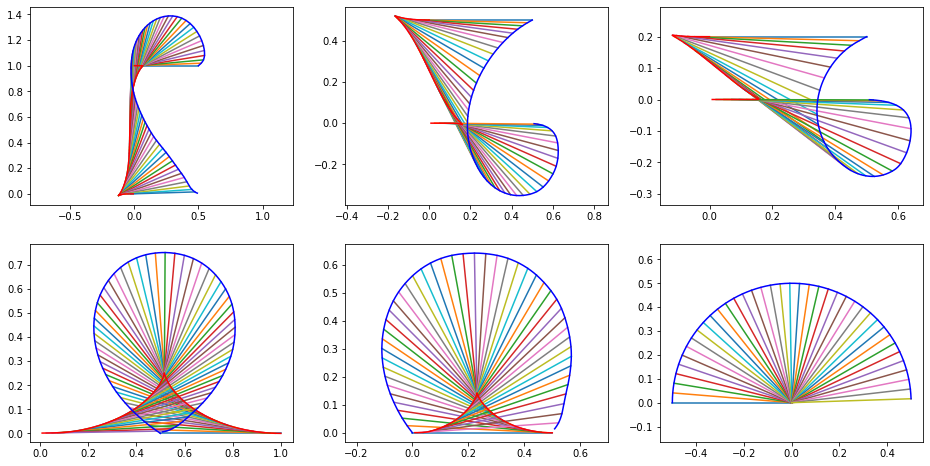

In [27]:
nx,ny=3,2
plt.figure(figsize=(16,12*ny/nx))
for i,geo in enumerate(hfmOut['geodesics']):
    if i>=nx*ny: break
    plt.subplot(ny,nx,1+i)
    back = geo[:2] # Note : exchanging front and back
    orient = geo[2]
    front = geo[:2] + r*ad.array((np.cos(orient),np.sin(orient)))
    plt.plot(*np.stack((front,back),axis=1)[:,:,::10]);
    plt.plot(*back,color='red')    
    plt.plot(*front,color='blue')
    plt.axis('equal')

## 3. Two trailers

The two trailer model is a rank two sub-Riemannian model, which for this reason is expected to be harder to solve numerically. 

### 3.1 Control vector fields

Again, we reproduce the two control vector fields defining the model, whose mathematical expression is given in the first section.

In [28]:
angles = xp.linspace(0,2*np.pi,96)
θs,ϕs = xp.meshgrid(angles,angles,indexing='ij')

In [29]:
def ω(θ,ϕ,κ0=1,κ1=1):
    z,u = np.zeros_like(θ), np.ones_like(θ)
    return np.stack(ad.asarray([
        [ np.cos(θ),np.sin(θ),z,κ1*np.sin(θ-ϕ)],
        [-np.sin(θ),np.cos(θ),κ0*u,z]
    ]),axis=1)

We also introduce two additional control vector fields, used in the Riemannian relaxation, which together with the first two span the tangent space.

In [30]:
def ω_(θ,ϕ,κ0=1,κ1=1):
    z,u = np.zeros_like(θ), np.ones_like(θ)
    ρ = -κ1*np.sin(θ-ϕ)
    return np.stack(ad.asarray([
        [ρ*np.cos(θ), ρ*np.sin(θ),z,u],
        [κ0*np.sin(θ),-κ0*np.cos(θ),u,z]
    ]),axis=1)

In [31]:
r0=0.2; κ0=1/r0
r1=0.2; κ1=1/r1
κs = [κ0,κ1]

In [32]:
assert allclose(lp.dot_VV(ω(θs,ϕs,*κs),ω_(θs,ϕs,*κs)),0)

In [33]:
H = Hamiltonian(ω(θs,ϕs,*κs),ω_(θs,ϕs,*κs))
print(f"Shape of the dual metric {H.shape}")

Shape of the dual metric (4, 4, 96, 96)


Looking at one of the Hamiltonian (symmetric positive definite) matrices, we find:
* A ratio approximately $0.1^2$ between the smallest and largest eigenvalue, which is expected in view of the relaxation parameter $\epsilon = 0.1$.
* A decomposition involving $12$ non-zero weights, associated with distinct offsets, which define the structure of the finite difference scheme.

In [34]:
Hi = H[:,:,12,19]
print(f"Eigenvalues at an arbitrary point {np.linalg.eigvalsh(Hi)}")
Eikonal.VoronoiDecomposition(Hi)

Eigenvalues at an arbitrary point [0.0599  0.26  5.99    26]


(array([0.00612, 0.376, 0.00612, 0.321, 0.322, 0.0174, 0.171, 0.232, 0.00612, 0.0448,  5.24, 0.325], dtype=float32),
 array([[-1, -1,  0,  0, -1,  0, -1, -1,  0, -1,  0,  0],
        [-1,  0, -1,  1,  0, -1, -1,  1, -2,  1,  0,  1],
        [ 1,  3, -2,  3,  3, -2,  0,  5, -5,  6,  1,  3],
        [ 3,  1,  1, -2,  2,  2,  3,  0,  3,  0,  0, -1]]))

In [35]:
Hi

array([[ 1.15,  -0.1, -3.53, -1.55],
       [ -0.1,  1.15,  3.47, -1.58],
       [-3.53,  3.47,    25,     0],
       [-1.55, -1.58,     0,     5]], dtype=float32)

### 3.2 Input

In [36]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann4',
    'seed':[0,0,0,0],
    'periodic':[True,True,True,True],
    'traits':{'niter_i':2,'shape_i':(4,4,4,2)},
    'raiseOnNonConvergence':False,
    'exportValues':True,
})
hfmIn.SetRect([[-0.5,0.5],[-0.5,0.5],[-np.pi,np.pi],[-np.pi,np.pi]],dims=[81,81,96,96]) # Largest on Shadow (Gtx 1080, 8Go)
hfmIn['origin'][2:] -= hfmIn['gridScales'][2:]/2 # Angular grid starts at -pi
hfmIn.SetUniformTips([4,4,4,1])

Our metric is translation invariant w.r.t the first two coordinates $X = (X_0,X_1)$, only depending on the *last two coordinates* the angle $\theta$ and $\phi$. This structure is relatively common, and the HFM library will take advantage of it to save some memory and compute less stencils.

In [37]:
_,_,aθ,aϕ = hfmIn.Axes()
assert np.allclose(aθ[0],-np.pi) and np.allclose(aϕ[0],-np.pi)
θs,ϕs = xp.meshgrid(aθ,aϕ,indexing='ij')

In [38]:
r0=0.2; κ0=1/r0
r1=0.2; κ1=1/r1
κs = [κ0,κ1]
hfmIn['dualMetric'] = Metrics.Riemann(Hamiltonian(ω(θs,ϕs,*κs),ω_(θs,ϕs,*κs),ϵ=0.04 ))

In [39]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 7.99450159072876 seconds, and 73 iterations.
Post-Processing


The spatial projections of the geodesics are even less informative than before.

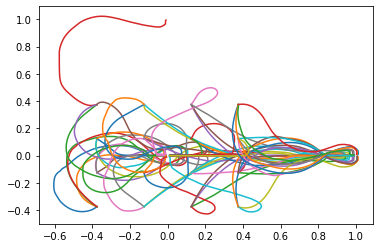

In [40]:
for geo in hfmOut['geodesics']:
    plt.plot(*geo[:2])

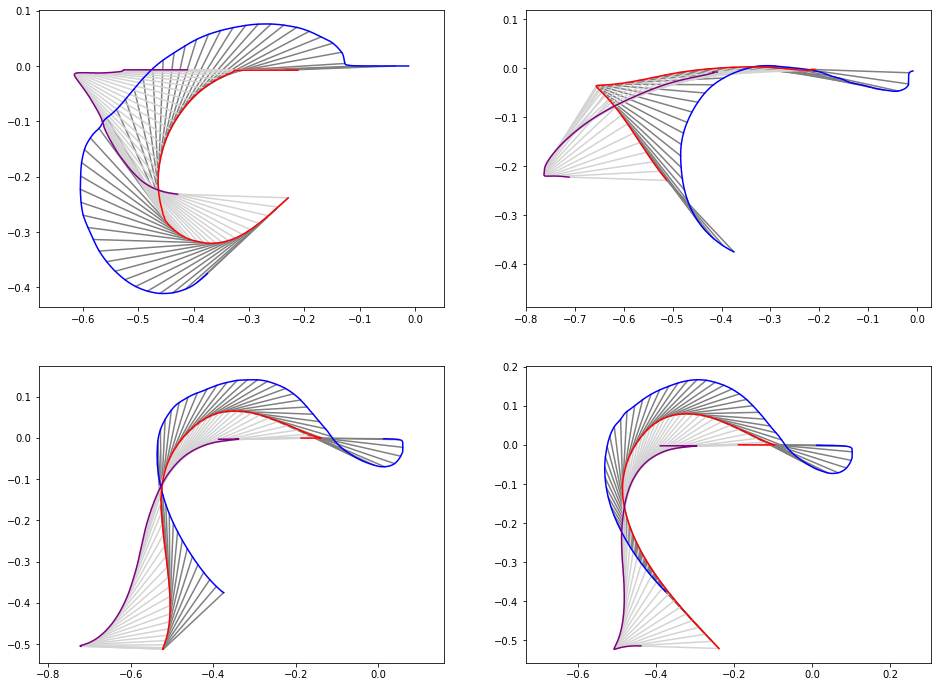

In [41]:
nx,ny=2,2
plt.figure(figsize=(16,12*ny/nx))
for i,geo in enumerate(hfmOut['geodesics']):
    if i>=nx*ny: break
    plt.subplot(ny,nx,1+i)
    front = geo[:2]
    orient = geo[2]; back0 = front - r0*ad.array((np.cos(orient),np.sin(orient)))
    orient = geo[3]; back1 = back0 - r1*ad.array((np.cos(orient),np.sin(orient)))
    
    plt.plot(*np.stack((front,back0),axis=1)[:,:,::10],color='gray');
    plt.plot(*np.stack((back0,back1),axis=1)[:,:,::10],color='lightgray');

    plt.plot(*front,color='blue')
    plt.plot(*back0,color='red')    
    plt.plot(*back1,color='purple')    
    plt.axis('equal')

### 3.3 Special motions

In [42]:
hfmIn['tips'] = [
    (0., 0.5,0.,0.), # Parallel parking, far
    (0.,0.35,0.,0.), # Parallel parking
    (0., 0.2,0.,0.), # Parallel parking, close
    (0,0,np.pi,np.pi), # Half turn, leaving head in place
    ( -r0,0,np.pi,np.pi), # Half turn, exchanging head and middle
    (-r0-r1,0,np.pi,np.pi), # Half turn, exchanging the head and tail
]
hfmIn['periodic']=[False,True,True,True]

In [43]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 9.326003551483154 seconds, and 82 iterations.
Post-Processing


The (approximate) optimal motions for parallel parking a half turn are shown below. Note that they feature many cusps.

**Failed close parallel parking.** In this test case, it is more advantageous to use the complementary vector fields, despite their strong penalization, than the control vector fields. That is why we see such an incorrect parallel translation.

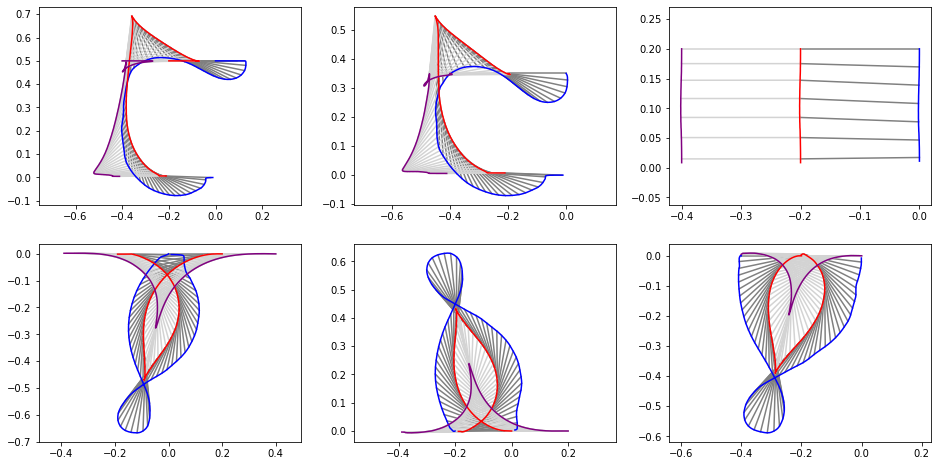

In [44]:
nx,ny=3,2
plt.figure(figsize=(16,12*ny/nx))
for i,geo in enumerate(hfmOut['geodesics']):
    if i>=nx*ny: break
    plt.subplot(ny,nx,1+i)
    front = geo[:2]
    orient = geo[2]; back0 = front - r0*ad.array((np.cos(orient),np.sin(orient)))
    orient = geo[3]; back1 = back0 - r1*ad.array((np.cos(orient),np.sin(orient)))
    
    plt.plot(*np.stack((front,back0),axis=1)[:,:,::10],color='gray');
    plt.plot(*np.stack((back0,back1),axis=1)[:,:,::10],color='lightgray');

    plt.plot(*front,color='blue')
    plt.plot(*back0,color='red')    
    plt.plot(*back1,color='purple')
    plt.axis('equal')

### 3.4 Comparison with the Reeds-Shepp car

An omni-directional vehicle with two trailers amounts to a Reeds-Shepp car with a single trailer. Similarly to the previous case, the isomorphism is obtained by using the back of the first trailer as a reference point.

We use this approach to obtain an alternative discretization of the problem of interest, and validate our numerical experiments.

In [60]:
angles = xp.linspace(0,2*np.pi,96)
θs,ϕs = xp.meshgrid(angles,angles,indexing='ij')

In [46]:
def ω(θ,ϕ,κ0=1,κ1=1):
    z,u = np.zeros_like(θ), np.ones_like(θ)
    return np.stack(ad.asarray([
        [np.cos(θ),np.sin(θ),z,κ1*np.sin(θ-ϕ)],
        [z,z,κ0*u,z]
    ]),axis=1)

We also introduce two additional control vector fields, used in the Riemannian relaxation, which together with the first two span the tangent space.

In [47]:
def ω_(θ,ϕ,κ0=1,κ1=1):
    z,u = np.zeros_like(θ), np.ones_like(θ)
    ρ = -κ1*np.sin(θ-ϕ)
    return np.stack(ad.asarray([
        [ρ*np.cos(θ), ρ*np.sin(θ),z,u],
        [ -np.sin(θ),   np.cos(θ),z,z]
    ]),axis=1)

In [48]:
r0=0.2; κ0=1/r0
r1=0.2; κ1=1/r1
κs = [κ0,κ1]

In [49]:
assert allclose(lp.dot_VV(ω(θs,ϕs,*κs),ω_(θs,ϕs,*κs)),0)

In [50]:
H = Hamiltonian(ω(θs,ϕs,*κs),ω_(θs,ϕs,*κs))
print(f"Shape of the dual metric {H.shape}")

Shape of the dual metric (4, 4, 96, 96)


Looking at one of the Hamiltonian (symmetric positive definite) matrices, we find:
* A ratio approximately $0.1^2$ between the smallest and largest eigenvalue, which is expected in view of the relaxation parameter $\epsilon = 0.1$.
* A decomposition involving $7$ non-zero weights, associated with distinct offsets, which define the structure of the finite difference scheme. There are also $5$ vanishing weights (up to numerical precision) in the decomposition.

In [51]:
Hi = H[:,:,12,19]
print(f"Eigenvalues at an arbitrary point {np.linalg.eigvalsh(Hi)}")
Eikonal.VoronoiDecomposition(Hi)

Eigenvalues at an arbitrary point [ 0.01 0.0599  5.99    25]


(array([0.00148,  0.01,     0, 0.00865, 0.509,    25, 0.0108, 0.326,     0, 2.98e-07,     0,     0], dtype=float32),
 array([[ 1,  0,  1,  0,  1,  0,  1,  0, -1,  1,  0,  0],
        [ 0, -1,  0, -1,  1,  0,  1,  0, -1,  1,  0,  0],
        [ 0,  0,  1,  0,  0, -1,  0,  0, -1,  1,  0,  0],
        [-1,  1, -1,  2, -3,  0, -2, -1,  2, -3,  0,  0]]))

Upon inspection, and a permutation of the last two axes, we find that the Hamiltonian matrix has a block diagonal structure, with blocks of sizes $3\times 3$ and $1 \times 1$. Recall that Voronoi's decomposition of a $3 \times 3$ matrix uses $6$ weights and offsets, and that one additional weight and offset is needed for the last $1 \times 1$ block. This explains why only 7 non-zero weights are involved in the decomposition of the the hamiltonians of this model.

In [52]:
Hi[[0,1,3,2]][:,[0,1,3,2]]

array([[0.521,  0.52, -1.55,     0],
       [ 0.52, 0.539, -1.58,     0],
       [-1.55, -1.58,     5,     0],
       [    0,     0,     0,    25]], dtype=float32)

In [61]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann4',
    'seed':[0,0,0,0],
    'traits':{'niter_i':2,'shape_i':(4,4,4,2)},
    'raiseOnNonConvergence':False,
    'exportValues':True,
})
hfmIn.SetRect([[-0.5,0.5],[-0.5,0.5],[-np.pi,np.pi],[-np.pi,np.pi]],dims=[81,81,96,96]) # Largest on Shadow (Gtx 1080, 8Go)

hfmIn['origin'][2:] -= hfmIn['gridScales'][2:]/2 # Angular grid starts at -pi
_,_,aθ,aϕ = hfmIn.Axes()
θs,ϕs = xp.meshgrid(aθ,aϕ,indexing='ij')

In [62]:
r0=0.2; κ0=1/r0
r1=0.2; κ1=1/r1
κs = [κ0,κ1]
hfmIn['dualMetric'] = Metrics.Riemann(Hamiltonian(ω(θs,ϕs,*κs),ω_(θs,ϕs,*κs),ϵ=0.06 ))

In [63]:
hfmIn['dualMetric'].m[:,:,5,8]

array([[  0.9, 0.304,     0,  0.92],
       [0.304, 0.107,     0, 0.312],
       [    0,     0,    25,     0],
       [ 0.92, 0.312,     0, 0.955]], dtype=float32)

In [64]:
hfmIn['tips'] = [
    (0., 0.5,0.,0.), # Parallel parking, far
    (0.,0.35,0.,0.), # Parallel parking
    (0., 0.2,0.,0.), # Parallel parking, close
    (2*r0,0,np.pi,np.pi), # Half turn, leaving head in place
    (  r0,0,np.pi,np.pi), # Half turn, exchanging head and middle
    (r0-r1,0,np.pi,np.pi), # Half turn, exchanging the head and tail
]
hfmIn['periodic']=[False,True,True,True]

In [65]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 9.278981685638428 seconds, and 83 iterations.
Post-Processing


We recognize the motions, although accuracy is not always at its best, with the following differences:
* The close parllel parking is slightly better extracted than before... Although one clearly sees that the motion of the second trailer substantially violates the sub-Riemannian constraint (side motion, not aligned with the trailer).
* The motion of the front of the car is less smooth, probably due to discretization.

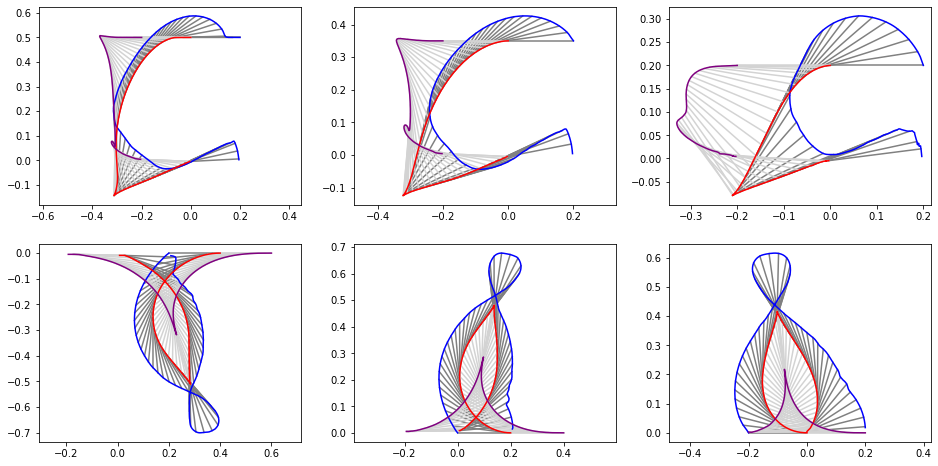

In [66]:
nx,ny=3,2
plt.figure(figsize=(16,12*ny/nx))
for i,geo in enumerate(hfmOut['geodesics']):
    if i>=nx*ny: break
    plt.subplot(ny,nx,1+i)
 
    back0 = geo[:2] 
    orient = geo[2]; front = back0 + r0*ad.array((np.cos(orient),np.sin(orient)))
    orient = geo[3]; back1 = back0 - r1*ad.array((np.cos(orient),np.sin(orient)))
     
    plt.plot(*np.stack((front,back0),axis=1)[:,:,::10],color='gray');
    plt.plot(*np.stack((back0,back1),axis=1)[:,:,::10],color='lightgray');

    plt.plot(*front,color='blue')
    plt.plot(*back0,color='red')    
    plt.plot(*back1,color='purple')    
    plt.axis('equal')